# **Elementary Reinforcement Learning**

Objectives: understanting the usage of environments in the [OpenAI Gym](https://www.gymlibrary.dev/) framework and  implement basic RL algorithms

1.   Manage to create custom environments from the OpenAI Gym framework
2.   Train Q-Learning on one of the custom environments and perform analysis regarding hyper-parameters







Install needed Python packages

In [146]:
!pip install pygame gym numpy

Import needed Python packages

In [147]:
import gym
from gym import spaces
import pygame
import numpy as np

Mount Google Drive for saving results (not needed if running the notebook locally)

In [148]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"         # default location for the drive

drive.mount(ROOT)              # we mount the google drive at /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1) Create Custom Environments**


## Definition of a simple grid environment
The agent needs to reach a target location in the grid represented by the target.
For the documentation of the `gym.Env` class visit: https://www.gymlibrary.dev/api/core/#gym-env

Implemented methods for this class are:

*   `__init__` needed for setting all basic variables of the environment
*   `step` and `reset` for respectively making a step into the agent-environment loop and resetting to initial state
*   `render` needed for visualization purposes
*   `_render_frame` private method for rendering frames
* `_get_obs` and `_get_info` are private methods needed for returning observations and info

The environment for a squared grid of size 5 looks like this:

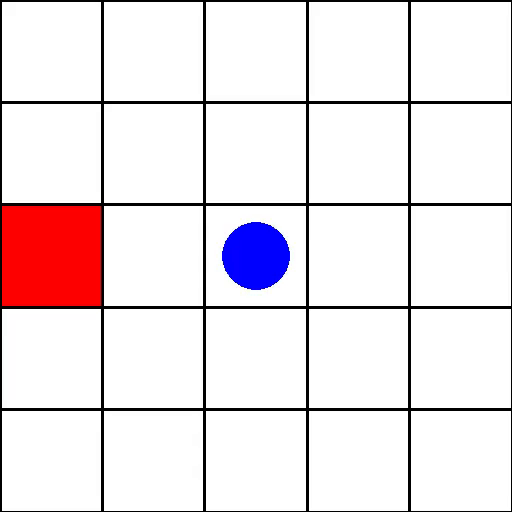

In [149]:
class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = spaces.Discrete(4)

        """
        The following dictionary maps abstract actions from `self.action_space` to
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

    # Private method to get observations
    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location}

    # Private method to get info
    def _get_info(self):
        return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}

    # Reset method for the environment
    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        # We will sample the target's location randomly until it does not coincide with the agent's location
        self._target_location = self._agent_location
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    # Step method for the environment
    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        # An episode is done iff the agent has reached the target
        terminated = np.array_equal(self._agent_location, self._target_location)
        reward = 1 if terminated else 0  # Binary sparse rewards
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info

    # Render method for visualization
    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )


Imports and functions for recording/showing videos for random policy on `GridEnv`

In [150]:
from gym.wrappers import RecordVideo
from pathlib import Path
import base64
from IPython import display as ipythondisplay

In [151]:
# Set up fake display; otherwise rendering will fail on Google Colab
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [152]:
def record_video_rand_gwenv(env, video_length=0, step_trigger=None, episode_trigger=None,  prefix='', video_folder='videos/'):

  video_env = RecordVideo(env,
                         video_folder=video_folder,
                         episode_trigger=episode_trigger,
                         step_trigger=step_trigger,
                         video_length=video_length,
                         name_prefix=prefix,
                         new_step_api=True
                         )

  observation, info = video_env.reset()

  step = 0
  ep = 0

  while True:

    if _iterate_condition(step, ep, video_length=video_length, step_trigger=step_trigger, episode_trigger=episode_trigger):

      observation, reward, terminated, _, info = video_env.step(env.action_space.sample())
      step += 1

      if terminated:
        observation, info = video_env.reset()
        ep += 1
        step = 0

    else:
      break

  video_env.close()

# Utility function for checking stopping condition
def _iterate_condition(step, ep, video_length=0, step_trigger=None, episode_trigger=None):

  if video_length is not 0:
    go = True if step < video_length else False
    return go

  if step_trigger is not None:
    go = step_trigger(step)
    return go

  if episode_trigger is not None:
    go = episode_trigger(ep)
    return go

<>:37: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:37: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-152-20cc7e5af827>:37: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if video_length is not 0:


In [153]:
def show_videos(video_path='', prefix=''):
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

Record video of ten steps for random policy on `GridEnv` environment

In [154]:
import sys
import os

is_colab = 'google.colab' in sys.modules
root_dir ='drive/MyDrive/CASAdML2024' if is_colab else '.'

In [155]:
video_folder = os.path.join(root_dir, 'Videos')
os.makedirs(video_folder, exist_ok=True)

prefix = 'gw_random'
grid_size = 5

# set video_length, episode_trigger, step_trigger
gwenv = GridWorldEnv(render_mode='rgb_array', size=grid_size)
record_video_rand_gwenv(gwenv,
                        video_length=0,
                        episode_trigger=lambda ep: (ep == 0),
                        step_trigger=None,
                        prefix=prefix,
                        video_folder=video_folder)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/CASAdML2024/Videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Play recorded video

In [156]:
show_videos(video_folder, prefix=prefix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Extension of `GridEnv` into `GridWorldBlindEnemyEnv`: adding another blind enemy agent

The task is to extend the previously defined environment into a more challenging scenario by inserting another agent that is going to eat our agent, if met. Precisely, the following rules should be satisfied:


*   The enemy agent should move randomly on the grid (i.e., the enemy does not know the position of our agent)
*   If our agent and enemy agent are on the same cell, the reward is -1 and the episode should terminate
* The starting positions for our and enemy agents should not coincide at episodes' start
* The enemy agent can't never reach the target location



In [159]:
class GridWorldBlindEnemyEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5):
      super().__init__()

      #Defining grid size and rendering settings
      self.size = size
      self.window_size = 512
      self.render_mode = render_mode

      #Define observation space with agent, target, and enemy location
      self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "enemy": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )

      # Define the action space for agent's actions (up, down, left, right)
      self.action_space = spaces.Discrete(4)

      # Mapping from action indices to movement directions
      self._action_to_direction = {
            0: np.array([1, 0]),   # right
            1: np.array([0, 1]),   # up
            2: np.array([-1, 0]),  # left
            3: np.array([0, -1]),  # down
        }
      # Ensure valid render_mode
      assert render_mode is None or render_mode in self.metadata["render_modes"]
      self.render_mode = render_mode

      # Initialize Pygame window and clock for rendering
      self.window = None
      self.clock = None

      # Initialize agent, target, and enemy locations
      self._agent_location = None
      self._target_location = None
      self._enemy_location = None


    def _get_obs(self):
        # Return the current positions of the agent, target, and enemy
        return {
            "agent": self._agent_location,
            "target": self._target_location,
            "enemy": self._enemy_location,
        }

    def _get_info(self):
        return None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        # Randomly choose the agent's location
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        # Randomly sample the target's location until it doesn't coincide with the agent's location
        self._target_location = self._agent_location
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        # Randomly choose the enemy agent's location until it doesn't coincide with the agent's location
        self._enemy_location = self._agent_location
        while np.array_equal(self._enemy_location, self._agent_location):
            self._enemy_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        observation = self._get_obs()

        if self.render_mode == "human":
            self._render_frame()

        return observation, {}

    def step(self, action):
        # Move the agent based on the chosen action
        direction = self._action_to_direction[action]
        self._agent_location = np.clip(self._agent_location + direction, 0, self.size - 1)

        # Randomly move the enemy agent
        enemy_action = self.np_random.choice(self.action_space.n)
        enemy_direction = self._action_to_direction[enemy_action]
        self._enemy_location = np.clip(self._enemy_location + enemy_direction, 0, self.size - 1)

        # Check if the episode should terminate
        terminated = np.array_equal(self._agent_location, self._target_location)
        reward = -1 if np.array_equal(self._agent_location, self._enemy_location) else (1 if terminated else 0)
        observation = self._get_obs()

        info={} #defining an empty info dictionary

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, info

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = self.window_size / self.size

        # Draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )

        # Draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Draw the enemy agent
        pygame.draw.circle(
            canvas,
            (255, 0, 0),
            (self._enemy_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            self.clock.tick(self.metadata["render_fps"])
        else:
            return np.transpose(np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2))

Record and check videos to assert that the environment works correctly (hint: use previously defined functions)

In [160]:
import os
import gym
import numpy as np

# Define the video folder and prefix
video_folder = 'videos_enemy'
os.makedirs(video_folder, exist_ok=True)
prefix = "gridworld_blind_enemy"

# Define grid size
grid_size = 5

# Create the environment
gwenv = GridWorldBlindEnemyEnv(render_mode='rgb_array', size=grid_size)

# Record a video
record_video_rand_gwenv(gwenv,
                        video_length=10,
                        episode_trigger=lambda ep: (ep == 0),
                        step_trigger=None,
                        prefix=prefix,
                        video_folder=video_folder)

# Show the recorded video
show_videos(video_folder, prefix)


/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos_enemy folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


## Extension of `GridWorldBlindEnemyEnv` into `GridWorldOracleEnemyEnv`: making the blind enemy agent more knwoledgable

An additional extension foresees the imporvement of the blind enemy agent into an oracle enemy agent (i.e., an enemy agent that knows the position of our agent). In this case, we modify one of the rules of the `GridWorldBlindEnemyEnv`:

*   The enemy agent should follow our agent on the grid (i.e., always making a step towards him)



In [ ]:
class GridWorldOracleEnemyEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5):
      pass

    def _get_obs(self):
        return None

    def _get_info(self):
        return None

    def reset(self, seed=None, options=None):
        return None

    def step(self, action):
        return None

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        pass


Record and check videos to assert that the environment works correctly (hint: use previously defined functions)

In [ ]:
# TO COMPLETE

# **2) Q-Learning**

## Q-Learning on `GridWorldEnv`

Function to inizialize the Q table

In [ ]:
def initializeQ(gwenv):
  Q = np.zeros((gwenv.size, gwenv.size,   # x and y for agent
                gwenv.size, gwenv.size,   # x and y for target
                gwenv.action_space.n))    # actions
  return Q


Function to run one episode of the algorithm on `GridWorldEnv`

In [ ]:
def run_episode_gwenv(env, Q, lr, discount, epsilon=0.1, render=False, _maxsteps=20, optimal=False):

	observation, _ = env.reset()
	done = False
	nsteps = 0

	for x in range(_maxsteps):

		nsteps += 1

		if done:
			break

		if render:
			env.render()

		curr_state = observation

		# handle multi dims of Q table
		ax = curr_state['agent'][0]
		ay = curr_state['agent'][1]
		tx = curr_state['target'][0]
		ty = curr_state['target'][1]

		# training time
		if not optimal:

			# Epsilon-greedy policy
			randnum = np.random.rand(1)
			if randnum < epsilon:
				action = env.action_space.sample()
			else:
				action = np.argmax(Q[ax, ay, tx, ty,:])

			observation, reward, done, _, info = env.step(action)

			# handle multi-dims of Q table
			ax_next = observation['agent'][0]
			ay_next = observation['agent'][1]
			tx_next = observation['target'][0]
			ty_next = observation['target'][1]

			#Q(state, action) = R(state, action) + Gamma * Max[Q(next state, all actions)]
			Q[ax, ay, tx, ty, action] += lr * (reward+ discount*np.max(Q[ax_next, ay_next, tx_next, ty_next, :]) - Q[ax, ay, tx, ty, action])

		# evaluation time
		else:
			action = np.argmax(Q[ax, ay, tx, ty,:])

			observation, reward, done, _, info = env.step(action)

	return Q, reward


Function to run Q-Learning

In [ ]:
from pyparsing.helpers import Callable
from tqdm import tqdm

def QLearning(env: gym.Env, num_episodes: int, initQ: Callable, run_episode: Callable, config: dict):

	reward_per_ep = list()
	Q = initQ(env)

	for i in tqdm(range(num_episodes)):
		Q, reward = run_episode(env, Q, **config)
		reward_per_ep.append(reward)

	return Q, reward_per_ep



Train Q-Learning on `GridWorldEnv`

In [ ]:
config = {}
config['lr'] = 0.1
config['discount'] = 0.99
config['epsilon'] = 0.2
num_episodes = 10000

Q_trained, reward_per_ep = QLearning(gwenv,
                                  	num_episodes,
																		initQ=initializeQ,
																		run_episode=run_episode_gwenv,
																		config=config)

Plot learning curve (i.e., average reward over fixed window)

In [ ]:
from matplotlib import pyplot as plt

def averagewindow(R, d=1):
    n = len(R)
    t = []
    y = []
    for i in range(0,int(n/d)):
        t.append(np.mean(range(i*d,(i+1)*d)));
        y.append(np.mean(R[i*d:min(n,(i+1)*d)]))
    return t,y

window = 100
t,y = averagewindow(reward_per_ep, d=window)
plt.plot(t, y)

Record video in inference mode

In [ ]:
config['optimal'] = True                  # no learning anymore
config['render'] = True                   # render for recording
initQ_trained = lambda env: Q_trained     # dummy function that returns the trained Q table
prefix = 'gwenv_q'
vid_episodes = 3

# use wrapper to record videos
gwenv_vid = RecordVideo(gwenv,
                        video_folder=video_folder,
                        episode_trigger=lambda ep: (ep < vid_episodes),
                        step_trigger=None,
                        video_length=0,
                        name_prefix=prefix,
                        new_step_api=True
                        )

# use wrapper to record videos
Q_trained, reward_per_ep_test = QLearning(gwenv_vid,
                                          num_episodes=vid_episodes,
                                          initQ=initQ_trained,
                                          run_episode=run_episode_gwenv,
                                          config=config)

Play videos over some episodes

In [ ]:
show_videos(video_folder, prefix=prefix)

## Q-Learning on `GridWorldBlindEnemyEnv` or `GridWorldOracleEnemyEnv`

The task is to train our virtual agent with Q-Learning on one of the two custom environments previously created.
Analyze the results concerning different hyper-parameters of the algorithm (e.g., impact of learning rate, discount factor, etc.).

In [ ]:
# TO COMPLETE